# Task 2


In [ ]:
### Libraries
import os
import numpy as np
import cv2 as cv
import glob
import importlib

importlib.reload(cv)
TEST = False

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
### Global Variables
trainDir = '../test'
testDir = "../test"
path_train_task2 = '../test/ground-truth/Task2/ground-truth'
path_results_task2 = "./Stegarescu_Ana-Maria_507/Task2"

In [ ]:
### Open Data & Sort
if not TEST:
    path_videos = trainDir + '/Task2/*.mp4'
    path_coordinates = trainDir + '/Task2/*.txt'
else:
    path_videos = testDir + '/Task2/*.mp4'
    path_coordinates = testDir + '/Task2/*.txt'

pathVideos = glob.glob(path_videos)
pathVideos = sorted(pathVideos, key = lambda i: int(os.path.splitext(os.path.basename(i))[0]))
pathCoordinates = glob.glob(path_coordinates)
pathCoordinates = sorted(pathCoordinates, key = lambda i: int(os.path.splitext(os.path.basename(i))[0]))

In [ ]:
### Read Coordinates
def read_coordinates():
    frame_count = []
    coordinates = []
    for i, aux in enumerate(pathCoordinates):
        with open(aux) as f:
            nr_frames = int(f.readline().split(' ')[0])
            frame_count.append(nr_frames)
            _, x1, y1, x2, y2 = f.readline().split()[:5]
            coordinates.append([int(x1), int(y1), int(x2), int(y2)])

    return frame_count, coordinates



frame_count, coordinates = read_coordinates()
# print(frame_count)
# print(coordinates)

In [ ]:
frame_count

[332, 491, 588, 419, 734, 1119, 410, 1028, 337, 402, 853, 361, 774, 299, 721]

In [ ]:
len(pathVideos)

15

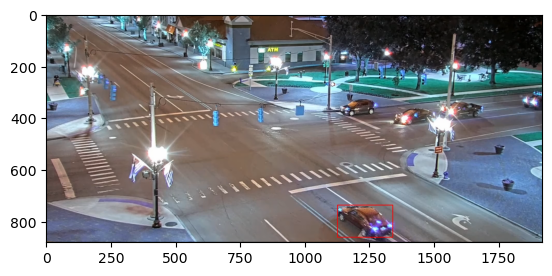

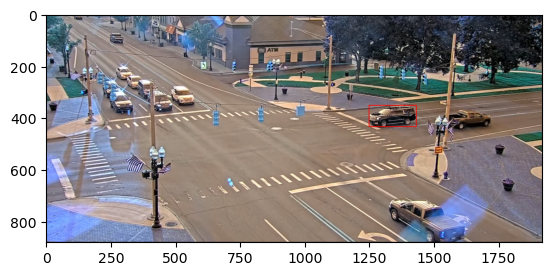

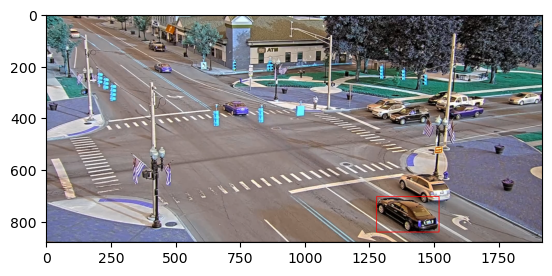

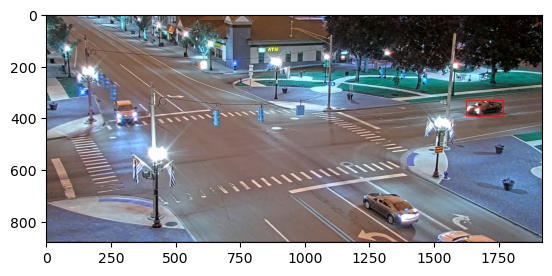

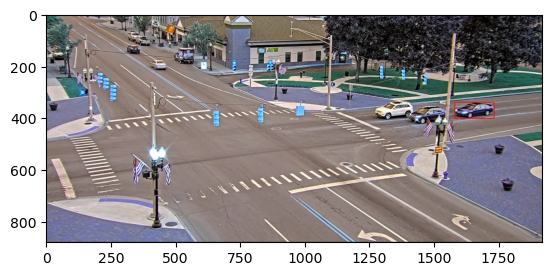

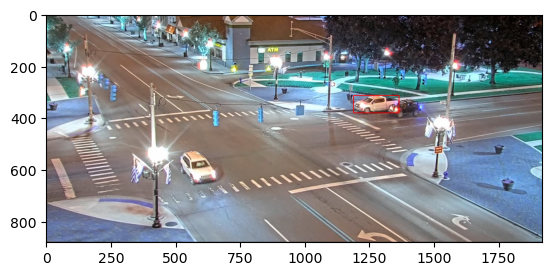

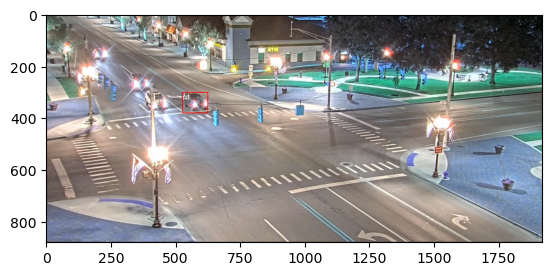

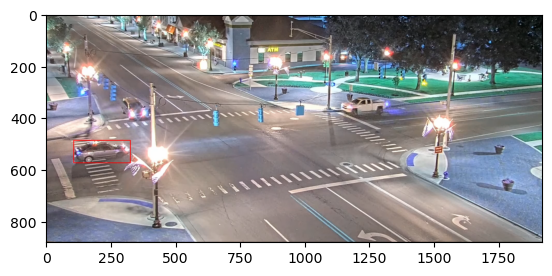

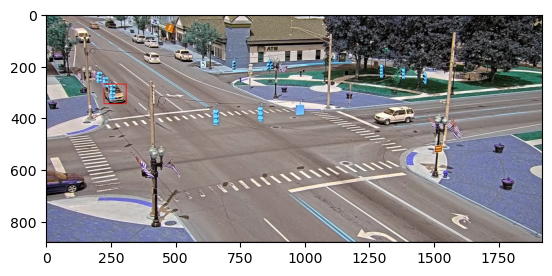

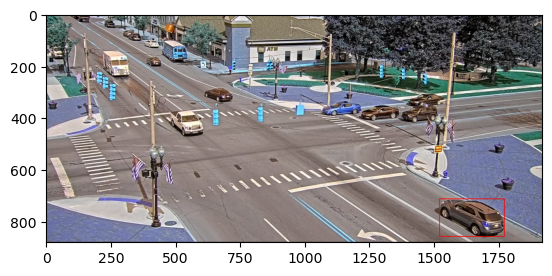

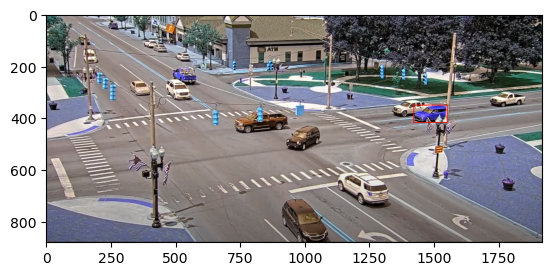

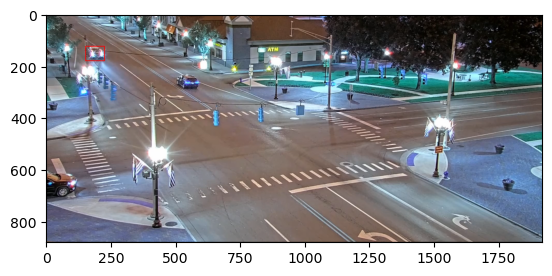

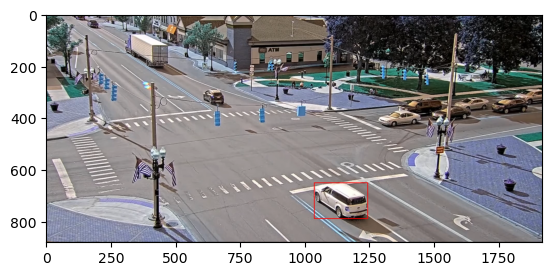

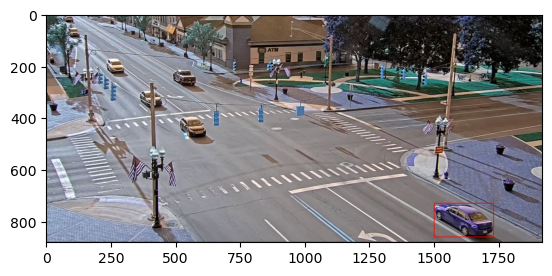

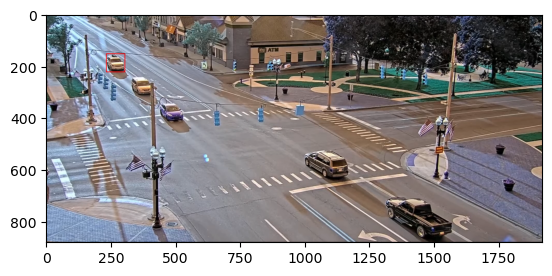

In [ ]:
### Map the coordinates for each video
def map_coordinates():
    coordinatesMap = { i:[] for i in range(1, len(pathVideos) + 1) }
    for i in range(15):
        tracker = cv.legacy.TrackerCSRT_create()
        curr_frame = 0

        vcap = cv.VideoCapture(pathVideos[i])
        _, frame = vcap.read()

        [x, y, z, w] = coordinates[i]
        box = (x, y, z - x, w - y)
        cv.rectangle(frame, (x, y), (z, w), (255, 0, 0), 2)
        plt.imshow(frame)
        plt.show()

        coordinatesMap[i + 1].append([curr_frame, int(box[0]), int(box[1]), int(box[0]) + int(box[2]), int(box[1]) + int(box[3])])
        tracker.init(frame, box)


        while True:
            ok, frame = vcap.read()
            if not ok:
                break

            curr_frame += 1
            ok, box = tracker.update(frame)

            if ok:
                cv.rectangle(frame, (int(box[0]), int(box[1])), (int(box[0] + box[2]), int(box[1] + box[3])), (255, 0, 0), 2, 1)

            #plt.imshow(frame)
            #plt.show()

            coordinatesMap[i + 1].append([curr_frame, int(box[0]), int(box[1]), int(box[0]) + int(box[2]), int(box[1]) + int(box[3])])
            if cv.waitKey(10) & 0xff == 27:
                break

        vcap.release()
        cv.destroyAllWindows()

    return coordinatesMap



coordinatesMap = map_coordinates()
# print(coordinatesMap)
# print(coordinatesMap[7])

In [ ]:
coordinatesMap.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [ ]:
### Write Predictions to .txt
for nr, coord in coordinatesMap.items():
    if not os.path.exists(path_results_task2):
        os.makedirs(path_results_task2)

    txt = ''
    if nr < 10:
        txt = '0' + str(nr)
    else:
        txt = str(nr)

    f = open(path_results_task2 + '/' + txt + '_predicted.txt', 'w')
    f.write(str(frame_count[nr - 1]) + ' -1 -1 -1 -1\n')

    for [c, x, y, w, z] in coord:
        f.write(str(c) + ' ' + str(x) + ' ' + str(y) + ' ' + str(w) + ' ' + str(z) + '\n')
    f.close()

In [ ]:
### Determine Intersection
def get_intersection(coordA, coordB):
    xA = max(coordA[0], coordB[0])
    yA = max(coordA[1], coordB[1])
    xB = min(coordA[2], coordB[2])
    yB = min(coordA[3], coordB[3])
    area = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    areaA = (coordA[2] - coordA[0] + 1) * (coordA[3] - coordA[1] + 1)
    areaB = (coordB[2] - coordB[0] + 1) * (coordB[3] - coordB[1] + 1)

    result = area / float(areaA + areaB - area)
    return result

In [ ]:
### Find Percentage
def find_percentage(coordinatesOriginal, coordinatesPredicted, nrFrames, verbose = 0):
    nrFrames = int(nrFrames)

    tp = 0
    fp = 0
    tn = 0
    fn = 0

    original_coord = {}
    for i in coordinatesOriginal:
        original_coord[i[0]] = i[1:]

    prediction_coord = {}
    for i in coordinatesPredicted:
        prediction_coord[i[0]] = i[1:]

    for i in range(nrFrames):
        if original_coord.get(i, None) is None and prediction_coord.get(i, None) is None:
            tn += 1

        elif original_coord.get(i, None) is not None and prediction_coord.get(i, None) is None:
            fn += 1

        elif original_coord.get(i, None) is None and prediction_coord.get(i, None) is not None:
            fp += 1

        elif original_coord.get(i, None) is not None and prediction_coord.get(i, None) is not None:
            intersection = get_intersection(original_coord[i], prediction_coord[i])
            if intersection >= 0.2:
                tp += 1
            else:
                fp += 1

    if verbose:
        print(f'True Positive = {tp}, True Negative = {tn}, False Positive = {fp}, False Negative = {fn}')
    assert tn + fn + tp + fp == nrFrames
    result = (tp + tn) / (tp + fp + tn + fn)

    return result

In [ ]:
path_results_task2 + "/" + name + "_predicted.txt"

In [ ]:
### Evaluation of Results
def evaluate_results(path_results_task2, path_train_task2, verbose = 0):
    nr_correct_videos = 0
    for i in range(1, 16):
        check = 0

        try:
            if(i < 10):
                name = '0' + str(i)
            else:
                name = str(i)

            filename_predictions = path_results_task2 + "/" + name + "_predicted.txt"
            filename_ground_truth = path_train_task2 + "/" + name + "_gt.txt"

            p = np.loadtxt(filename_predictions)
            coordinatesPredicted = p[1:]
            gt = np.loadtxt(filename_ground_truth)
            coordinatesOriginal = gt[1:]
            nrFrames = gt[0][0]
            percentage = find_percentage(coordinatesOriginal, coordinatesPredicted, nrFrames, verbose)

            check = 1
            if percentage < 0.8:
                check = 0
                print(i)
            else:
                print(percentage)

            if verbose:
                print("Percentage = ", percentage)
                print("For test ", str(i), " the prediction = ", (1 - check) * "in" + "correct", "\n")

            nr_correct_videos = nr_correct_videos + check

        except:
            print("Error")

        points = nr_correct_videos * 0.15

    return nr_correct_videos, points

In [ ]:
if not TEST:
    print(evaluate_results(path_results_task2, path_train_task2, verbose = 0))

1
0.9816700610997964
1.0
4
5
0.8668453976764968
7
8
9
10
0.9871043376318874
0.9695290858725761
1.0
14
15
(6, 0.8999999999999999)
